
I have recieved "train_val" file containing 4 files , out of which one can understand 2 of them represent "fake" people - using ipad, iphone to showcase their faces and "real" people - representing real people.

**problem statement:**
to my understanding the task is to be able to classify between a fake and a real image/frame.

**plan of atack:**

I will follow the general machine learning workflow.

1. Examine and understand the data
2. Build an input pipeline, in this case using Keras ImageDataGenerator
3. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
2. Evaluate model 

**and more precisely:**

1. I will need to download teh "train_val" folder into my PC for ease of use. 
2. explore the vids 
3. create directory tree that will include a master/root directory and 2 sub_directories that will be named after the categories to be classified. 
4. transform the .ds files into .jpg/.png image files by sub-sampling the video (every 30 frames). 
5. comming back to step 3 above , all the sampled images will be stored and mapped into the 2 different classes (using their path name "Fake" or else.. 
6. explore the image folders - checking for un-balancing and outliers 
7. treat step 6 by applying upsampling method (data augmentation) to the smaller category "fake" and cleaning both folders from dark, saturated , corrupted , backgrounds etc. images
8. now that the data is balanced and clean , start "learning" process

**use the following:**
1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. I will simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

I do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/

https://medium.com/backprop-labs/face-recognition-pipeline-clearly-explained-f57fc0082750

# In Case you have GPU 

In [ ]:
# Make sure that the GPU is available and the version is 2.0 or higher
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available()  #>>> True

# Import reaquired packages

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
    
import glob
import shutil
from os.path import join, isfile , isdir, sep, dirname
from os import listdir, getcwd, chdir
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast, RandomZoom

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Creating a main_dir : "Dataset_Homeasignment" -> a sub_dir : "vids" -> 2 x sub_dirs : "fake" , "real"

In [2]:
PATHS = {'MASTER':'/Users/gilli/Downloads/', 
         'CALLBACKS': '/Users/gilli/Downloads/Dataset_homeAssignment/callbacks/',
         'VIDS_RAW': '/Users/gilli/Downloads/train_val/',
         'VIDS_TRAIN': '/Users/gilli/Downloads/Dataset_homeAssignment/vids/',
         'PROJ_NAME': '/Users/gilli/Downloads/Dataset_homeAssignment/',
         'IMGS': '/Users/gilli/Downloads/Dataset_homeAssignment/images/',
         'TRAIN_VAL': '/Users/gilli/Downloads/Dataset_homeAssignment/images/train/',
         'TEST': '/Users/gilli/Downloads/Dataset_homeAssignment/images/test/',
         'BALANCE_AUG': '/Users/gilli/Downloads/Dataset_homeAssignment/generated_fake/',
        }

In [ ]:
count_r, count_f = 0, 0
## looping over all the .DS files and routing them between "fake" and "real"
for name_path in glob.glob(join(PATHS['VIDS_RAW'], '**/*.ts'),recursive=True):
    print('[COPYING FILES]...')
    if 'FakeData' in name_path:
        shutil.copy(name_path, PATHS['VIDS_TRAIN'] + 'fake')
        count_f+=1
    else:
        shutil.copy(name_path, PATHS['VIDS_TRAIN'] + 'real')
        count_r+=1

print('\t', 'Total of {} files were copied'.format(count_r+count_f))
print('\t', '{} real files'.format(count_r))
print('\t', '{} fake files'.format(count_f))

Creating sub_dir under main_dir -> "images" -> sub_dir : "train_val" -> x2 sub_dirs : "fake", "real"

Converting the video files (.TS) into frames (.JPG) and 

Coppying the image files into the relevant sub_dirs : "fake", "real" 

In [ ]:
def vid2img(video_file, dir_name, length, currentframe, save_every_num_frame):
    # assuming 30fps than take a single frame every 30 frames (1fps)
    cap = cv2.VideoCapture(video_file)
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if not ret:
            break
            
        image = frame.copy()
        # resizing the images by 40% inorder to save space 
        image = cv2.resize(image, (0,0), fx=0.4,fy=0.4, interpolation=cv2.INTER_AREA)
        
        # copying the 30th frame 
        if currentframe % save_every_num_frame == 0:
            cv2.imwrite(PATHS['TRAIN_VAL'] + dir_name + '/img_' + str(int(currentframe/save_every_num_frame)
                                                              + length) + '.jpg',image)
            print('[INFO] saved image {}'.format(currentframe))
        currentframe += 1
    cap.release()
    
# looping over the class dirs "fake" and "real"
for dir_name in listdir(PATHS['VIDS_TRAIN']):
    
    # exncluding '.DS_Store' file
    if 'Store' not in dir_name:
        
        # looping over all the video files in a class dir
        for video_file in glob.glob(join(PATHS['VIDS_TRAIN'], dir_name + '/*')):
            if isfile(video_file):
                size = len(listdir(join(PATHS['TRAIN_VAL'], dir_name)))
                print('\t', video_file)
                vid2img(video_file, dir_name, size, 0, 30)

## Data Engineering

1) checking for un-balanced dataset 

2) checking for outliers - corrupted, saturated , dark, irrelevant etc. images

In [ ]:
print('There are: {} "real" images in our dataset'.format(len(listdir(join(PATHS['TRAIN_VAL'], 'real')))))
print('There are: {} "fake" images in our dataset'.format(len(listdir(join(PATHS['TRAIN_VAL'], 'fake')))))

# Data Cleaning 

### methods
1) manual -> selective screening (corrupted images, BG images, images that are not unique 

2) face detected -> stays

3) person detected -> stays

I have manually (10min work) removed all outlyers

# Un-Balanced Data

since the data is not balanced I have :
    
1) upsampled (Dataset generation and data expansion) the "fake" images

2) regardless I have removed all outliers and managed to reduce the "real" dir size 

In [ ]:
# load the input image, convert it to a NumPy array, and then
# reshape it to have an extra dimension
count , i = 1, 1
print(' [INFO] loading images ...')
for image_path in glob.glob(join(PATHS['TRAIN_VAL'], 'fake/*')):
    
    image = load_img(image_path)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    # construct the image generator for data augmentation then
    # initialize the total number of images generated thus far
    augment_obj = ImageDataGenerator(
        rotation_range=30,
        brightness_range=(0.2, 0.8),
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    
    total = 0
    
    # construct the actual Python generator
    image_Gen = augment_obj.flow(image, batch_size=1, save_to_dir=PATHS['BALANCE_AUG'],
        save_prefix="img_gen", save_format="jpg", shuffle=True)
    
    # loop over examples from our image data augmentation generator
    for image in image_Gen:
        # increment our counter
        total += 1
        # if we have reached the specified number of examples, break
        # from the loop
        if total == 3:
            break
    
    if count*total % 600 == 0:
        print('[INFO] {} images were generated'.format(i*total*count))
        i+=1
        
    count+=1
     
print('[INFO] generated {} images...'.format(len(listdir(PATHS['BALANCE_AUG']))-1))

Copying the new generated image files into the old "fake" images folder

In [ ]:
count = 0
print('[COPYING FILES]...')
for name_path in glob.glob(PATHS['BALANCE_AUG'] + '*'):
    shutil.copy(name_path, PATHS['TRAIN_VAL'] + 'fake/')
    count+=1

print('[INFO] {} images were copied into {} '.format(count, PATHS['TRAIN_VAL'] + 'fake/'))
print('[INFO] Now, there are {} image files in fake dir'.format(len(os.listdir(PATHS['TRAIN_VAL'] + 'fake/'))))

Verifying that the data is balanced (difference of 1% is OK)

In [ ]:
print('[INFO] {} images were copied into {}'.format(count, PATHS['TRAIN_VAL'] + 'fake/'))
print('[INFO] Now, there are {} image files in "fake" DIR'.format(len(listdir(PATHS['TRAIN_VAL'] + 'fake/'))))
print('[INFO] Now, there are {} image files in "real" DIR'.format(len(listdir(PATHS['TRAIN_VAL'] + 'real/'))))

Taking a moment to show the Tree structure of the project dir

In [77]:
chdir(PATHS['PROJ_NAME'])

In [78]:
! tree -d 

.
├── callbacks
├── clean
├── generated_fake
├── images
│   ├── test
│   │   ├── fake
│   │   └── real
│   └── train
│       ├── fake
│       └── real
└── vids
    ├── fake
    └── real

13 directories


In [79]:
chdir(PATHS['MASTER'])

# Transfer learning and fine-tuning

In [6]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data download

In this part, I will use the generated images dataset to create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility.

In [7]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

1) The idea is to generate : training dataset and validation dataset from the "train-val" folder I have created.

2) create "test_dataset" for model evaluation from the validation dataset (20% of it).

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  PATHS['TRAIN_VAL'],
  labels="inferred",
  label_mode="int",
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
  )

Found 20184 files belonging to 2 classes.
Using 16148 files for training.


In [9]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  PATHS['TRAIN_VAL'],
  labels="inferred",
  label_mode="int",
  validation_split=0.2,
  shuffle=True,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
  )

Found 20184 files belonging to 2 classes.
Using 4036 files for validation.


In [10]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  PATHS['TEST'],
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
  )

Found 2484 files belonging to 2 classes.


Show 4 images per label class from the training set:

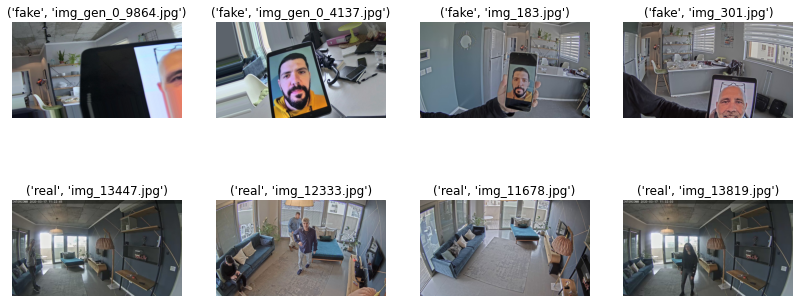

In [11]:
import matplotlib.image as mpimg
%matplotlib inline

number_classes = len(train_dataset.class_names)
image_indexes = [7025, 356, 5365, 26]
selected_image_file_paths = dict()

for classification in train_dataset.class_names:
    image_directory = join(PATHS['TRAIN_VAL'], classification)
    images_file_names = listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, images_file_names[i]) for i in image_indexes]

plt.figure(figsize=(14, 6))
for i,classification in enumerate(train_dataset.class_names):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(number_classes,4,image_number)
        plt.title((classification,image.split(sep)[-1]))
        plt.axis("off")
        plt.imshow(mpimg.imread(image))

# SKIP until " Use Data Augmentation"

As I have mentioned above , since the dataset doesn't contains a test set, I will create one. To do so, I will determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then I'll move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches:{}'.format(tf.data.experimental.cardinality(validation_dataset)))
print('Number of test batches:{}'.format(tf.data.experimental.cardinality(test_dataset)))

### Configure the dataset for performance

This is a good practice to use buffered prefetching to load images from disk without having I/O become blocking.  [data performance](https://www.tensorflow.org/guide/data_performance).

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

It is consered a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [12]:
Aug_train = tf.keras.Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.2),
  RandomContrast((0.2,0.8)),
  RandomZoom(0.1, fill_mode='nearest')
])

I have applyed these layers to the same image in order to visualize the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


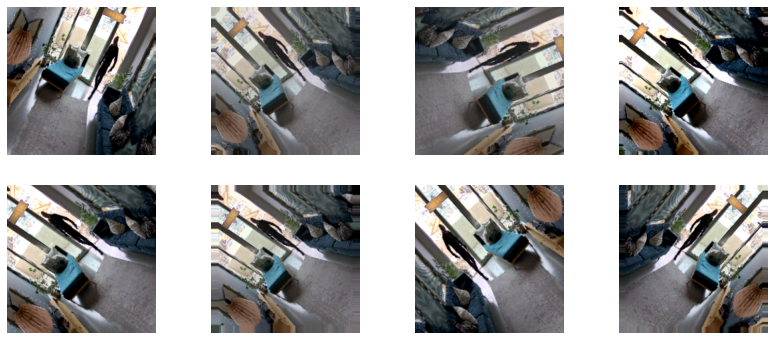

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(14, 6))
  first_image = image[3]
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    augmented_image = Aug_train(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

I will use the `tf.keras.applications.MobileNetV2` for use as my base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in my images are in `[0-255]`. To rescale them, I have used the preprocessing method included with the model.

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, I could rescale pixel values from `[0,255]` to `[-1, 1]` using a Rescaling layer.

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Create the base model from the pre-trained convnets
I chose to use the base model **MobileNet V2** as its a lean yet very accurate model. This is pre-trained on the ImageNet dataset.

First, I will instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, I will load the network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `224x224x3` image into a `7x7x1280` block of features. Let's see what it does to an example batch of images:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


## Feature extraction
In this step, I'll freeze the convolutional base created from the previous step and use as a feature extractor. Additionally, I'll add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [17]:
base_model.trainable = False

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [75]:
len(base_model.layers)

154

# Add a classification head

To generate predictions from the block of features, I'll average over the spatial `7x7` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


I'll apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. since this prediction will be treated as a `logit` there is no actual need of an activation layer.  Positive numbers predict class 1, negative numbers predict class 0.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# Build Model Pipeline 

Build a model pipeline by stacking together the data augmentation, rescaling, base_model and feature extractor layers. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [22]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = Aug_train(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, I'll use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

I can see that, there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between the two `tf.Variable` objects, the weights and biases.

In [25]:
len(model.trainable_variables)

2

## DEFINE CALLBACK

In [26]:
checkpoint_path = PATHS['CALLBACKS'] + 'cp.ckpt'
checkpoint_dir = dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True
                                                 verbose=1)

### Train the model
The initial acc is < 50%

In [27]:
loss0, accuracy0 = model.evaluate(validation_dataset)

127/127 [==============================] - 66s 502ms/step - loss: 0.8148 - accuracy: 0.4843


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.48


In [29]:
initial_epochs = 5

In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback])

Epoch 1/5
505/505 [==============================] - 357s 701ms/step - loss: 0.3256 - accuracy: 0.8558 - val_loss: 0.1494 - val_accuracy: 0.9913

Epoch 00001: saving model to /Users/gilli/Downloads/Dataset_homeAssignment/callbacks/cp.ckpt
Epoch 2/5
505/505 [==============================] - 358s 707ms/step - loss: 0.0957 - accuracy: 0.9817 - val_loss: 0.0745 - val_accuracy: 0.9950

Epoch 00002: saving model to /Users/gilli/Downloads/Dataset_homeAssignment/callbacks/cp.ckpt
Epoch 3/5
505/505 [==============================] - 356s 703ms/step - loss: 0.0554 - accuracy: 0.9903 - val_loss: 0.0474 - val_accuracy: 0.9960

Epoch 00003: saving model to /Users/gilli/Downloads/Dataset_homeAssignment/callbacks/cp.ckpt
Epoch 4/5
505/505 [==============================] - 361s 713ms/step - loss: 0.0382 - accuracy: 0.9934 - val_loss: 0.0349 - val_accuracy: 0.9968

Epoch 00004: saving model to /Users/gilli/Downloads/Dataset_homeAssignment/callbacks/cp.ckpt
Epoch 5/5
505/505 [=========================

After training for only 5 epochs, I got ~99% accuracy on the validation set.

# save model

In [31]:
model.save(PATHS['CALLBACKS'] + "Liveness_model.h5")

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

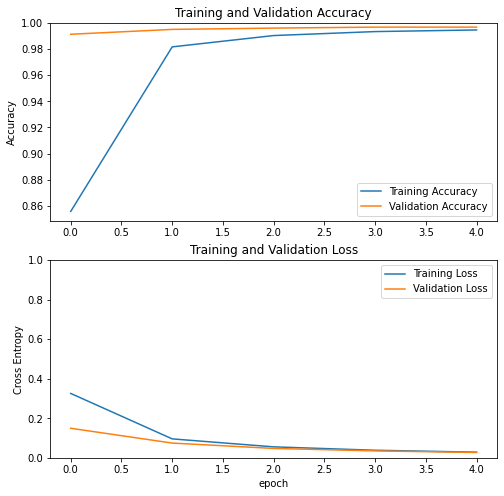

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1]
Labels:
 [1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1]


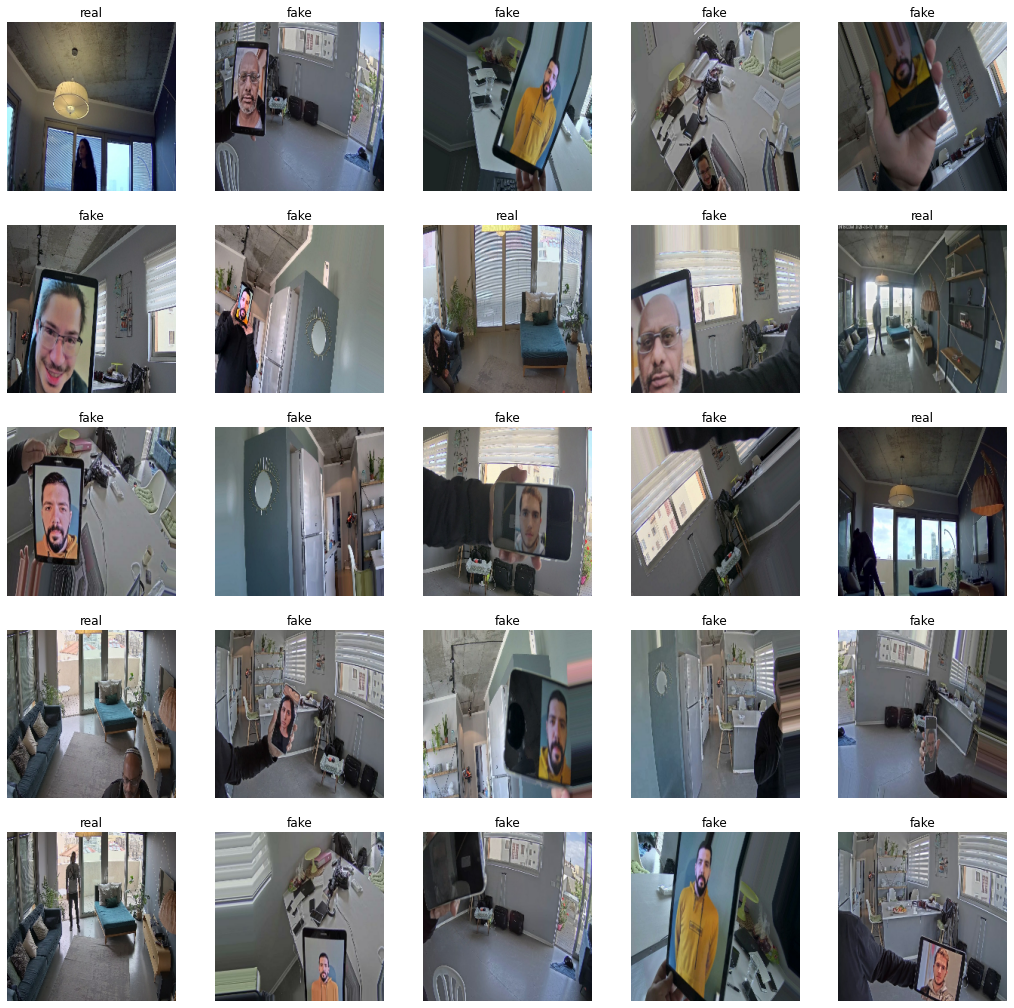

In [33]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
class_names = test_dataset.class_names
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(18, 18))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Liveliness RT test 

1. score 
scoring is given between 0.0 and 1.0 where the closer it is to 0.0 it means it is "FAKE" and vice versa.

2. timing
Took all parts of the video inference pipline - loading the model, cloning frame, color convertion (BGR->RGB), image resizing (224,224), image rescaling [0 -255] -> [-1, 1] , frame inference time

In [36]:
from tensorflow.keras.models import load_model
from collections import deque
import time

print('[INFO] loading model ...\n')
start_model_loading = time.time()
model_timing = load_model(PATHS['CALLBACKS'] + 'Liveness_model.h5')
model_loading_time = (time.time() - start_model_loading)
classes = ['FAKE', 'REAL'] #test_dataset.class_names

mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")

Q = [] 
T_new = np.zeros((6,))
timing = ['model_loading_time', 'frame_cloning', 'color_convertion', 
          'image_resize', 'image_rescaling', 'inference']
frame_count = 1

cap = cv2.VideoCapture(PATHS['VIDS_TRAIN'] + 'fake/SafeGuardFakeData_19676_FakePhone_18032020_BBULLET_RGB_001.ts')

# loop over frames from the video file stream
print('[INFO] looping over frames from the video file stream ...\n')
while (cap.isOpened()):
    
    ret, frame = cap.read()
  
    if not ret:
        break
        
    # clone the output frame, 
    start_frame_cloning = time.time()
    output = frame.copy()
    frame_cloning = (time.time() - start_frame_cloning)
    
    # convert IMG_FORMART to RGB
    start_CVT = time.time()
    output = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    color_convertion = (time.time() - start_CVT)
        
    # RESIZE the frame to IMG_SIZE - 224x224
    start_resize = time.time()
    output = cv2.resize(output, (224, 224)).astype("float32")
    image_resize = (time.time() - start_resize)
        
    # PIXEL_RESCALING using mean subtraction 
    start_local_avg = time.time()
    output -= mean
    image_rescaling = (time.time() - start_local_avg)
    
    start_inference = time.time()
    # make predictions on the frame 
    preds = model_timing.predict(np.expand_dims(output, axis=0))[0]
    inference = (time.time() - start_inference)
    
    
    T_old = np.array([model_loading_time, frame_cloning, color_convertion, 
                      image_resize, image_rescaling, inference])
    T_new += T_old
    
    
    preds = tf.nn.sigmoid(preds)
    preds = tf.where(preds < 0.5, 0, 1)
    
    Q.append(preds)
    
    frame_count +=1

res = np.array(Q).mean(axis=0)[0]
label = classes[int(res)]

print('[NUM_OF_FRAMES] {}\n'.format(frame_count))
print('[LIVENESS_SCORE] (0.0-1.0) : {}\n'.format(np.round(res,5))
for ind in range(len(T_new)):
    print('The MEAN TIME FOR {} WAS: {}ms\n'.format(timing[ind],np.round(T_new[ind]/frame_count, 5)))

cap.release()

[INFO] loading model ...

[INFO] looping over frames from the video file stream ...

[NUM_OF_FRAMES] 1136

[LIVENESS_SCORE] (0.0-1.0) : 0.02026431718061674

The MEAN TIME FOR model_loading_time WAS: 1.11305ms

The MEAN TIME FOR frame_cloning WAS: 0.00388ms

The MEAN TIME FOR color_convertion WAS: 0.00289ms

The MEAN TIME FOR image_resize WAS: 0.00165ms

The MEAN TIME FOR image_rescaling WAS: 0.0003ms

The MEAN TIME FOR inference WAS: 0.04289ms



## Fine tuning
One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

I'll fine-tune a small number of top layers rather than the whole MobileNet model. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, I'll recompile the model (necessary for these changes to take effect), and resume training.

In [37]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As I'm training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [39]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [41]:
len(model.trainable_variables)

56

### Continue training the model

In [42]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset
                         callbacks=[cp_callback])

Epoch 5/15
505/505 [==============================] - 467s 916ms/step - loss: 0.0082 - accuracy: 0.9978 - val_loss: 0.0064 - val_accuracy: 0.9985
Epoch 6/15
505/505 [==============================] - 464s 916ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0020 - val_accuracy: 0.9990
Epoch 7/15
505/505 [==============================] - 475s 938ms/step - loss: 5.4264e-04 - accuracy: 0.9999 - val_loss: 0.0010 - val_accuracy: 0.9995
Epoch 8/15
505/505 [==============================] - 471s 930ms/step - loss: 8.9999e-04 - accuracy: 0.9997 - val_loss: 9.6232e-04 - val_accuracy: 0.9995
Epoch 9/15
505/505 [==============================] - 477s 941ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9990
Epoch 10/15
505/505 [==============================] - 462s 911ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 0.9995
Epoch 11/15
505/505 [==============================] - 3699s 7s/step - loss: 8.1680e-04 - accuracy: 0.9996 - va

In [44]:
model.save(PATHS['CALLBACKS'] + "Liveness_Tuned_model.h5")

## Visualizing the acc/loss

After fine tuning the model nearly reaches 99% accuracy on the validation set.

In [45]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

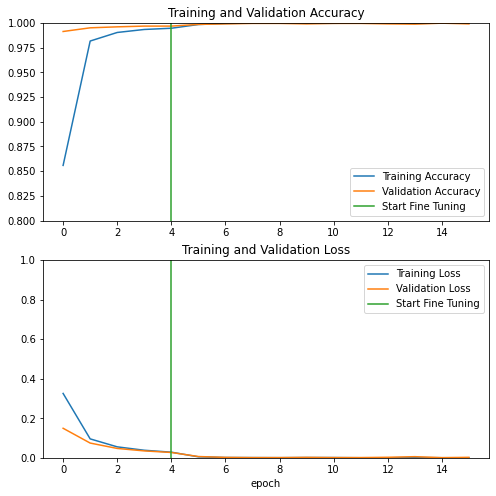

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

verify the performance of the model on new data using test set.

In [47]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

78/78 [==============================] - 44s 541ms/step - loss: 1.1757e-04 - accuracy: 1.0000
Test accuracy : 1.0


predict if the scene is a fake or real.

Predictions:
 [0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1]
Labels:
 [0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1]


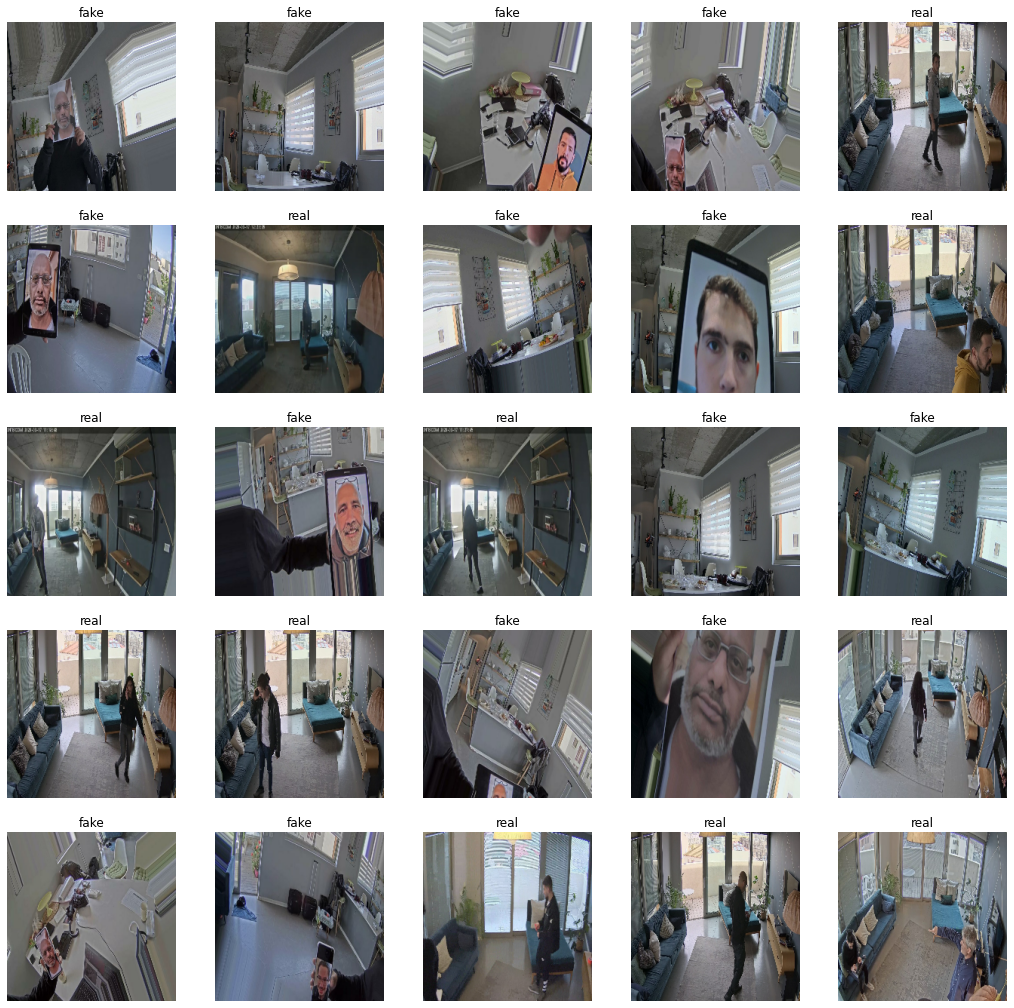

In [48]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(18, 18))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")